In [4]:

import pandas as pd
# from experiments.musique.inference_only import macro_averaging
from knowledge_propagation.utils import io, vars, extractor
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import describe
from thefuzz import fuzz

from collections import Counter
from knowledge_propagation.modules.evaluators import (
    ExactMatchEvaluator,
    RougeEvaluator,
    OpenAIEvaluator,
)
llm_evaluator = OpenAIEvaluator()
from typing import List, Dict, Tuple

os.getcwd()
def macro_averaging(df: pd.DataFrame, metrics: List[str], multi_level_averaging: List[str]):
    """
    Do macro-averaging over the given metrics and multi-level averaging categories.
    """
    extracted_multi_level_cols = [[m, "mean"] for m in metrics]
    while len(multi_level_averaging) > 0:
        # first take the mean over each generation,
        # and, only take `mean` of `rouge1` and  `llm_accuracy` column groups
        df_over_cols = df.groupby(multi_level_averaging, observed=True).describe()[extracted_multi_level_cols]
        # remove the multi-level column indices, since there's only one sub-level -- "mean"
        df_over_cols.columns = df_over_cols.columns.get_level_values(0)

        # reset index to flatten the multi-level column indices for the next macro-averaging class
        df = df_over_cols.reset_index(inplace=False)
        multi_level_averaging.pop(-1)
    return df

# Country results

In [277]:
n_seen_template = 1
n_seen_cities = 350

all_templates = io.load_jsonlines("/data/users/zliu/KE-by-CP/data/debug_meta_train/country_syn_data_v2/data_gen/all_templates_reordered.jsonl")
template2tag = io.load_json("/data/users/zliu/KE-by-CP/data/debug_meta_train/country_syn_data_v2/data_gen/place_template2template_tag.json")
id_templates = all_templates[:n_seen_template]
# ood_templates = all_templates[n_seen_template:]
# ood_templates = all_templates[-2:]
id_template_tags = [template2tag[t] for t in id_templates]
ood_template_tags = [template2tag[t] for t in ood_templates]

seen_pair_seen_country_df = pd.read_excel(f"/data/users/zliu/mend/country_exp_out/3K_heavy_noshare_mid-upper3_template-{n_seen_template}_seen-{n_seen_cities}/country_syn_v2/mend_eval_loss=clm_input=seen_n=100_prompt=no_w-gen_wo-icl_e_seen_pair_seen_country.xlsx")
unseen_pair_seen_country_df = pd.read_excel(f"/data/users/zliu/mend/country_exp_out/3K_heavy_noshare_mid-upper3_template-{n_seen_template}_seen-{n_seen_cities}/country_syn_v2/mend_eval_loss=clm_input=seen_n=100_prompt=no_w-gen_wo-icl_e_unseen_pair_seen_country.xlsx")
unseen_pair_unseen_country_df = pd.read_excel(f"/data/users/zliu/mend/country_exp_out/3K_heavy_noshare_mid-upper3_template-{n_seen_template}_seen-{n_seen_cities}/country_syn_v2/mend_eval_loss=clm_input=seen_n=100_prompt=no_w-gen_wo-icl_e_unseen_pair_unseen_country.xlsx")


In [243]:
# macro_averaging(df, multi_level_averaging=["stage", "input"], metrics=metrics) * 100
# macro_averaging(df, multi_level_averaging=["question_type", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", '[Q][A] Acc EM', "[Q][A] Acc PM"] + ["exact_match", "llm_accuracy"]).round(2)

In [244]:
# macro_averaging(df[df["question_key"] == "question"], multi_level_averaging=["question_tag", "id"], metrics=["exact_match", "llm_accuracy"]).round(2)
# macro_averaging(df[(df["question_type"] == "efficacy-ood") & (df["question_key"] == "question")], multi_level_averaging=["question_type", "question_tag", "id"], metrics=["exact_match", "llm_accuracy"]).round(2)

In [256]:
base_df = pd.read_excel("/data/users/zliu/mend/country_exp_out/llama3.2-1B-eos-sft-country-template-format-lr2e-6/ood_v3_prefilter/base_n=1185_prompt=no_w-gen_wo-icl_ice=False.xlsx")
base_df = base_df.dropna(subset=["question"], inplace=False)
question2llmacc = dict(zip(base_df["question"], base_df["llm_accuracy"]))

assert all([q in question2llmacc for q in seen_pair_seen_country_df[seen_pair_seen_country_df["question_key"] == "unalias_question"]["question"].tolist()])
assert all([q in question2llmacc for q in unseen_pair_seen_country_df[unseen_pair_seen_country_df["question_key"] == "unalias_question"]["question"].tolist()])
assert all([q in question2llmacc for q in unseen_pair_unseen_country_df[unseen_pair_unseen_country_df["question_key"] == "unalias_question"]["question"].tolist()])

# Measure model performance

In [278]:
print("Seen template:",  n_seen_template, "seen cities:", n_seen_cities)


seen_template_seen_pair_seen_country_df = seen_pair_seen_country_df[(seen_pair_seen_country_df["question_key"] == "question") & (seen_pair_seen_country_df["question_tag"].isin(id_template_tags))]
print("seen city, seen country:", (seen_template_seen_pair_seen_country_df.describe()["llm_accuracy"]["mean"] * 100).round(1))

seen_template_unseen_pair_seen_country_df = unseen_pair_seen_country_df[(unseen_pair_seen_country_df["question_key"] == "question") & (unseen_pair_seen_country_df["question_tag"].isin(id_template_tags))]
print("unseen city, seen country:", (seen_template_unseen_pair_seen_country_df.describe()["llm_accuracy"]["mean"] * 100).round(1))

seen_template_unseen_pair_unseen_country_df = unseen_pair_unseen_country_df[(unseen_pair_unseen_country_df["question_key"] == "question") & (unseen_pair_unseen_country_df["question_tag"].isin(id_template_tags))]
print("unseen city, unseen country:", (seen_template_unseen_pair_unseen_country_df.describe()["llm_accuracy"]["mean"] * 100).round(1))

Seen template: 1 seen cities: 350
seen city, seen country: 97.3
unseen city, seen country: 82.0
unseen city, unseen country: 32.7


In [279]:
print("[Unseen template], seen template: ",  n_seen_template, "seen cities:", n_seen_cities)
unseen_template_seen_pair_seen_country_df = seen_pair_seen_country_df[(seen_pair_seen_country_df["question_key"] == "question") & (seen_pair_seen_country_df["question_tag"].isin(ood_template_tags))]
print(f"seen city, seen country ({len(unseen_template_seen_pair_seen_country_df)}):", (unseen_template_seen_pair_seen_country_df.describe()["llm_accuracy"]["mean"] * 100).round(1))

unseen_template_unseen_pair_seen_country_df = unseen_pair_seen_country_df[(unseen_pair_seen_country_df["question_key"] == "question") & (unseen_pair_seen_country_df["question_tag"].isin(ood_template_tags))]
print(f"unseen city, seen country ({len(unseen_template_unseen_pair_seen_country_df)}):", (unseen_template_unseen_pair_seen_country_df.describe()["llm_accuracy"]["mean"] * 100).round(1))

unseen_template_unseen_pair_unseen_country_df = unseen_pair_unseen_country_df[(unseen_pair_unseen_country_df["question_key"] == "question") & (unseen_pair_unseen_country_df["question_tag"].isin(ood_template_tags))]
print(f"unseen city, unseen country ({len(unseen_template_unseen_pair_unseen_country_df)}):", (unseen_template_unseen_pair_unseen_country_df.describe()["llm_accuracy"]["mean"] * 100).round(1))


[Unseen template], seen template:  1 seen cities: 350
seen city, seen country (200): 52.2
unseen city, seen country (200): 48.0
unseen city, unseen country (200): 33.0


# Measure base Knowledge level

In [180]:
print("Seen template:",  n_seen_template)

seen_template_seen_pair_seen_country_questions = seen_pair_seen_country_df[(seen_pair_seen_country_df["question_key"] == "unalias_question") & (seen_pair_seen_country_df["question_tag"].isin(id_template_tags))]["question"].tolist()
print("seen city, seen country:", (np.mean([question2llmacc[q] for q in seen_template_seen_pair_seen_country_questions]) * 100).round(1))

seen_template_unseen_pair_seen_country_questions = unseen_pair_seen_country_df[(unseen_pair_seen_country_df["question_key"] == "unalias_question") & (unseen_pair_seen_country_df["question_tag"].isin(id_template_tags))]["question"].tolist()
print("unseen city, seen country:", (np.mean([question2llmacc[q] for q in seen_template_unseen_pair_seen_country_questions]) * 100).round(1))

seen_template_unseen_pair_unseen_country_questions = unseen_pair_unseen_country_df[(unseen_pair_unseen_country_df["question_key"] == "unalias_question") & (unseen_pair_unseen_country_df["question_tag"].isin(id_template_tags))]["question"].tolist()
print("unseen city, unseen country:", (np.mean([question2llmacc[q] for q in seen_template_unseen_pair_unseen_country_questions]) * 100).round(1))

Seen template: 5
seen city, seen country: 91.4
unseen city, seen country: 91.8
unseen city, unseen country: 88.6


In [280]:
print("Unseen template:",  len(ood_template_tags))
unseen_template_seen_pair_seen_country_questions = seen_pair_seen_country_df[(seen_pair_seen_country_df["question_key"] == "unalias_question") & (seen_pair_seen_country_df["question_tag"].isin(ood_template_tags))]["question"].tolist()
print(f"seen city, seen country ({len(unseen_template_seen_pair_seen_country_questions)}):", (np.mean([question2llmacc[q] for q in unseen_template_seen_pair_seen_country_questions]) * 100).round(1))

unseen_template_unseen_pair_seen_country_questions = unseen_pair_seen_country_df[(unseen_pair_seen_country_df["question_key"] == "unalias_question") & (unseen_pair_seen_country_df["question_tag"].isin(ood_template_tags))]["question"].tolist()
print(f"unseen city, seen country ({len(unseen_template_unseen_pair_seen_country_questions)}):", (np.mean([question2llmacc[q] for q in unseen_template_unseen_pair_seen_country_questions]) * 100).round(1))

unseen_template_unseen_pair_seen_uncountry_questions = unseen_pair_unseen_country_df[(unseen_pair_unseen_country_df["question_key"] == "unalias_question") & (unseen_pair_unseen_country_df["question_tag"].isin(ood_template_tags))]["question"].tolist()
print(f"unseen city, unseen country ({len(unseen_template_unseen_pair_seen_uncountry_questions)}):", (np.mean([question2llmacc[q] for q in unseen_template_unseen_pair_seen_uncountry_questions]) * 100).round(1))


Unseen template: 2
seen city, seen country (200): 99.2
unseen city, seen country (200): 99.8
unseen city, unseen country (200): 100.0


In [137]:
len(seen_template_unseen_pair_seen_country_questions)

100

np.float64(90.5)

In [42]:
# df = pd.read_excel("/u/zliu/datastor1/mend/debug_exp_output/Llama-3.2-1B-common-country-eos-sft_clm-baseline_lr=1e-05_epoch=4.0_tunable-params=midupper3-mlp/all_results_id+ood_v2_text.xlsx")
df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/common-country_3K_heavy_share_mid-upper3/country_syn/mend_eval_loss=clm_input=seen_n=100_prompt=no_w-gen_wo-icl_e_all_propagation_ood_v2-question.xlsx")
print("Num of rows:", len(df))
df["predicted_answer"] = df["predicted_answer"].astype(str)
# df["is_num"] = df["is_num"].astype(int)

Num of rows: 11368


In [3]:
# df[df["question_type"] == "efficacy-ood"].sort_values(by=["id", "question"]).to_excel("/u/zliu/datastor1/mend/debug_exp_output/Llama-3.2-1B-common-country-eos-sft_clm-baseline_lr=1e-05_epoch=4.0_tunable-params=midupper3-mlp/all_results_ood_v2_text.xlsx", index=False)

In [ ]:
# df[df["question_key"] == "question"].sort_values(by=["id", "question"]).to_excel("/u/zliu/datastor1/mend/debug_exp_output/common-country_3K_heavy_noshare_mid-upper3/country_syn/mend_eval_loss=clm_input=seen_n=100_prompt=no_w-gen_wo-icl_e_all_propagation_ood_v2-question_only_ood.xlsx", index=False)

In [13]:
df["question_key"].unique()

array(['question'], dtype=object)

In [5]:
macro_averaging(df[(df["question_type"] == "efficacy") & (df["question_key"] == "question")], multi_level_averaging=["question_tag", "id"], metrics=["llm_accuracy"]).round(2)

,question_tag,llm_accuracy
0,efficacy_common_fact_birth_place,0.37
1,efficacy_common_fact_career_place,0.29
2,efficacy_common_fact_death_place,0.29


In [ ]:
macro_averaging(df[(df["question_type"] == "efficacy-ood") ], multi_level_averaging=["question_tag", "id"], metrics=["llm_accuracy"]).round(2)

In [96]:
# len(df[df["question_key"] == "question"])
df[df["question_key"] == "question"]["question_tag"].value_counts().to_dict()

{'efficacy_common_fact_death_place': 384,
 'efficacy_common_fact_career_place': 372,
 'efficacy_common_fact_birth_place': 367}

In [ ]:
macro_averaging(df[df["question_key"] == "question"], multi_level_averaging=["question_key", "id"], metrics=[ "llm_accuracy"]).round(2)

In [11]:
# macro_averaging(df, multi_level_averaging=["question_type", "id"], metrics=[ "is_num", "abs_diff", "llm_accuracy"]).round(2)
macro_averaging(df[(df["question_key"] == "unaliased_question")], multi_level_averaging=["question_key", "id"], metrics=[ "llm_accuracy"]).round(2) #  & (df["question_type"] == "efficacy-ood")
# macro_averaging(df[df["question_key"] == "unaliased_question"], multi_level_averaging=["question_key", "id"], metrics=[ "llm_accuracy"]).round(2)

,question_key,llm_accuracy
0,unaliased_question,0.74


In [12]:
(0.74 - 0.1) / 0.9

0.7111111111111111

In [43]:
# len(df[(df["question_key"] == "question") & (df["question_type"] == "efficacy-ood")])
df[(df["question_key"] == "question") & (df["question_type"] == "efficacy-ood")].describe()

,id,predicted_answer_idx,exact_match,llm_accuracy
count,1123.000000,1123.0,1123.000000,1123.000000
mean,49.625111,0.0,0.096171,0.230721
std,28.962653,0.0,0.294957,0.304790
min,0.000000,0.0,0.000000,0.100000
25%,24.000000,0.0,0.000000,0.100000
50%,50.000000,0.0,0.000000,0.100000
75%,75.000000,0.0,0.000000,0.100000
max,99.000000,0.0,1.000000,1.000000


In [27]:
macro_averaging(df[(df["question_key"] == "question") & (df["question_type"] == "efficacy-ood")], multi_level_averaging=["question_key", "id"], metrics=[ "llm_accuracy"]).round(2)

,question_key,llm_accuracy
0,question,0.2


In [26]:
valid_df_content = []
for i in range(len(df)):
    r = df.iloc[i]
    if any(x in r["predicted_answer"].lower() for x in ["yes", "no"]):
        valid_df_content.append(r)
valid_df = pd.DataFrame(valid_df_content)
len(valid_df)

61

In [126]:
macro_averaging(valid_df, multi_level_averaging=["question_tag", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", "exact_match", "llm_accuracy"]).round(2)

,question_tag,[A]|[Q] Acc EM,[A]|[Q] Acc PM,exact_match,llm_accuracy
0,ood_efficacy_border,0.00,0.50,0.00,0.52
1,ood_efficacy_non_border,0.14,0.57,0.14,0.23


In [101]:
valid_df.describe()[["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", "exact_match", "llm_accuracy",]].round(2)

,[A]|[Q] Acc EM,[A]|[Q] Acc PM,exact_match,llm_accuracy
count,31.0,31.00,31.0,31.00
mean,0.0,0.48,0.0,0.65
std,0.0,0.09,0.0,0.43
min,0.0,0.00,0.0,0.10
25%,0.0,0.50,0.0,0.10
50%,0.0,0.50,0.0,1.00
75%,0.0,0.50,0.0,1.00
max,0.0,0.50,0.0,1.00


In [184]:
for q_tag, q_df in df[df["stage"] == "pre-edit"].groupby("question_tag"):
    print(q_tag + ":", sum(isinstance(x, str) for x in q_df["predicted_answer"].to_list()))

multi_hop_efficacy_q0: 999
single_hop_efficacy_q0: 802
single_hop_efficacy_q1: 744


In [45]:
dev_ids = [ex["id"] for ex in io.load_jsonlines(f"{vars.DATA_DIR}/musique_mend/2hop_musique_ans_v1.0_dev.jsonl")[:1000]]

In [151]:
save_dir = "/u/zliu/datastor1/mend/debug_exp_output/Llama-3.2-1B-common-date-year-after-eos-sft_clm-baseline_lr=1e-05_epoch=4.0_tunable-params=all/individual_results_id+ood_v2_text_w-icl=True"
all_df = pd.concat([pd.read_excel(f) for f in glob(f"{save_dir}/*.xlsx", recursive=True)])
len(all_df)

6384

In [152]:
all_df.to_excel(f"{save_dir}/../all_results_id+ood_v2_text_w-icl=True.xlsx", index=False)

In [6]:
all_df["is_num"] = all_df["is_num"].astype(float)

In [ ]:
all_df.describe()

,id,answer,predicted_answer_idx,exact_match,is_num,abs_diff,diff,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM
count,100.000000,100.000000,100.0,100.000000,100.000000,73.000000,73.000000,100.000000,100.000000,100.0,100.000000
mean,49.500000,1957.310000,0.0,0.310000,0.730000,13.493151,8.041096,0.300000,0.790000,0.0,0.438087
std,29.011492,30.458017,0.0,0.464823,0.446196,15.383183,18.859450,0.460566,0.161746,0.0,0.068536
min,0.000000,1904.000000,0.0,0.000000,0.000000,0.000000,-48.000000,0.000000,0.500000,0.0,0.285714
25%,24.750000,1932.750000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.0,0.418731
50%,49.500000,1954.500000,0.0,0.000000,1.000000,10.000000,0.000000,0.000000,0.750000,0.0,0.428571
75%,74.250000,1977.500000,0.0,1.000000,1.000000,20.000000,19.000000,1.000000,1.000000,0.0,0.500000
max,99.000000,2022.000000,0.0,1.000000,1.000000,61.000000,61.000000,1.000000,1.000000,0.0,0.611111


In [20]:
(macro_averaging(all_df, multi_level_averaging=["question_type", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", ] + ["exact_match", "is_num", "abs_diff", "diff"])).round(2) # llm_accuracy '[Q][A] Acc EM', "[Q][A] Acc PM"

,question_type,[A]|[Q] Acc EM,[A]|[Q] Acc PM,exact_match,is_num,abs_diff,diff
0,efficacy,0.00,0.58,0.00,0.77,13.68,9.57
1,specificity,0.23,0.76,0.23,1.00,6.99,1.22


In [25]:
efficacy_df = all_df[all_df["question_type"] == "efficacy"]

In [30]:
nan_efficacy_df = efficacy_df[efficacy_df["is_num"] == 0]

In [12]:
# for i, row in nan_efficacy_df.iterrows():
#     print(row["question"])
#     print(row["predicted_answer"])
#     print()

In [13]:
# born_question = 0
# for i, row in efficacy_df.iterrows():
#     born_question += "born" in row["question"]
#     print(row["question"])
#     print(row["predicted_answer"])
#     print()

In [24]:
mend_1k_n_question_efficacy = pd.read_excel("/u/zliu/datastor1/mend/debug_exp_output/common-date-year-after_1K/bio_syn/mend_eval_loss=clm_input=seen_n=100_prompt=no_w-gen_wo-icl_e_n-question.xlsx")

In [25]:
mend_1k_n_1_question_efficacy = pd.read_excel("/u/zliu/datastor1/mend/debug_exp_output/common-date-year-after_1K/bio_syn/mend_eval_loss=clm_input=seen_n=100_prompt=no_w-gen_wo-icl_e_n+1-question.xlsx")

In [26]:
len(mend_1k_n_question_efficacy[mend_1k_n_question_efficacy["exact_match"] == 1])

14

In [36]:
mend_1k_n_question_correct_ids = set((mend_1k_n_question_efficacy[mend_1k_n_question_efficacy["exact_match"] == 1]["id"].to_list()))

In [35]:
mend_1k_n_1_question_correct_ids = set(mend_1k_n_1_question_efficacy[mend_1k_n_1_question_efficacy["exact_match"] == 1]["id"].to_list())

In [37]:
mend_1k_n_question_correct_ids

{20, 28, 35, 38, 41, 46, 48, 50, 54, 56, 76, 82, 84, 89}

In [39]:
mend_1k_n_1_question_correct_ids.intersection(mend_1k_n_question_correct_ids)

{89}

In [40]:
len(mend_1k_n_1_question_correct_ids)

62

# OOD knowledge v2

In [ ]:
# sft_train = io.load_jsonlines(f"{vars.DATA_DIR}/debug_meta_train/common_country_data/train_country.jsonl") + io.load_jsonlines(f"{vars.DATA_DIR}/debug_meta_train/common_country_data/train_continent.jsonl")
# sft_valid = io.load_jsonlines(f"{vars.DATA_DIR}/debug_meta_train/common_country_data/valid_country.jsonl") + io.load_jsonlines(f"{vars.DATA_DIR}/debug_meta_train/common_country_data/valid_continent.jsonl")

# # io.dump_jsonlines(sft_train, f"{vars.DATA_DIR}/debug_meta_train/common_country_data/train.jsonl")
# # io.dump_jsonlines(sft_valid, f"{vars.DATA_DIR}/debug_meta_train/common_country_data/valid.jsonl")

In [41]:
# df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-common-date-year-after-eos-sft/ood_v2_prefilter/base_n=1085_prompt=no_w-gen_wo-icl_ice=False.xlsx")
model_name = "llama3.2-1B-eos-sft"
model_name = "llama3.2-1B-eos-sft-country-template-format-lr1e-6"
# model_name = "llama3.2-1B-common-country-eos-sft"
# model_name = "llama3.2-1B"
add_icl = False

df = pd.read_excel(f"/u/zliu/datastor1/mend/debug_exp_output/{model_name}/ood_v2_prefilter/base_n=1085_prompt=no_w-gen_w{'' if add_icl else 'o'}-icl_ice=False.xlsx")
df = df.drop_duplicates(subset=['question'], keep='first')


place_ood_templates = [
    "What is the capital of {country}?",
    'What language has the most speakers in {country}?',
    "What is the currency of {country}?",
    "Which ethnic group is the largest in {country}?",
    "Which country is the largest in {continent} by area?",
    "Which religion has the most followers in {country}?"
]
place_template2template_tag = {
    "What is the capital of {country}?": "country->capital",
    'What language has the most speakers in {country}?': "country->language",
    "What is the currency of {country}?": "country->currency",
    "Which ethnic group is the largest in {country}?": "country->ethnic_group",
    "Which country is the largest in {continent} by area?": "continent->largest_country",
    "Which religion has the most followers in {country}?": "country->religion",
}

# 
df = df[df["domain"] == "country"]


df["template_tag"] = df.apply(lambda r: place_template2template_tag[r["template"]], axis=1)
selected_columns_ood_df = df[["question", "answer", "predicted_answer", "template_tag", "domain", "llm_accuracy"]]

In [42]:
country_train_df = pd.read_excel(f"/u/zliu/datastor1/mend/debug_exp_output/{model_name}/common_train/base_n=584_prompt=no_w-gen_w{'' if add_icl else 'o'}-icl_ice=False.xlsx")
country_dev_df = pd.read_excel(f"/u/zliu/datastor1/mend/debug_exp_output/{model_name}/common/base_n=81_prompt=no_w-gen_w{'' if add_icl else 'o'}-icl_ice=False.xlsx")
country_df = pd.concat([country_train_df, country_dev_df]).drop_duplicates(subset=['question'], keep='first')
country_df["template_tag"] = country_df.apply(lambda r: "city->country" if "country" in r["question"] else "country->continent", axis=1)
# country_df["template_tag"] = country_df.apply(lambda r: "city->country" if "country" in r["question"].split("\n")[-2] else "country->continent", axis=1)
country_df["domain"] = "country"
selected_columns_country_df = country_df[["question", "answer", "predicted_answer", "template_tag", "domain", "llm_accuracy"]]

In [43]:
selected_columns_country_df.iloc[0]["question"]

'What country is Accra in?'

In [44]:
len(df.drop_duplicates(subset=['question'], keep='first'))

336

In [45]:
# df.head(1)
df[df["domain"] == "country"].describe()

,id,predicted_answer_idx,exact_match,abs_diff,diff,contain_ans,llm_accuracy
count,336.000000,336.0,336.000000,0.0,0.0,336.00000,336.000000
mean,884.005952,0.0,0.687500,NaN,NaN,0.71131,0.891369
std,115.226940,0.0,0.464204,NaN,NaN,0.45383,0.260682
min,689.000000,0.0,0.000000,NaN,NaN,0.00000,0.100000
25%,783.750000,0.0,0.000000,NaN,NaN,0.00000,1.000000
50%,882.500000,0.0,1.000000,NaN,NaN,1.00000,1.000000
75%,983.250000,0.0,1.000000,NaN,NaN,1.00000,1.000000
max,1084.000000,0.0,1.000000,NaN,NaN,1.00000,1.000000


In [46]:
selected_columns_ood_df

,question,answer,predicted_answer,template_tag,domain,llm_accuracy
689,What is the capital of France?,Paris,Paris,country->capital,country,1.0
690,What language has the most speakers in France?,French,French,country->language,country,1.0
691,What is the currency of France?,Euro,Euro,country->currency,country,1.0
692,Which ethnic group is the largest in France?,French,French,country->ethnic_group,country,1.0
693,Which country is the largest in Europe by area?,Russia,Russia,continent->largest_country,country,1.0
...,...,...,...,...,...,...
1080,What is the capital of French Polynesia?,Papeete,Papeete,country->capital,country,1.0
1081,Which religion has the most followers in Frenc...,Christianity,Roman Catholic,country->religion,country,0.7
1082,Which ethnic group is the largest in French Po...,Polynesians,Polynesians,country->ethnic_group,country,1.0
1083,What is the currency of French Polynesia?,French Pacific Franc,French Pacific Franc,country->currency,country,1.0


In [47]:
df.groupby("key").describe()["llm_accuracy"].reset_index()

,key,count,mean,std,min,25%,50%,75%,max
0,Algeria,5.0,0.94,0.134164,0.7,1.0,1.0,1.0,1.0
1,Argentina,5.0,0.86,0.313050,0.3,1.0,1.0,1.0,1.0
2,Armenia,5.0,1.00,0.000000,1.0,1.0,1.0,1.0,1.0
3,Australia,5.0,0.82,0.402492,0.1,1.0,1.0,1.0,1.0
4,Austria,5.0,0.94,0.134164,0.7,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
61,Ukraine,5.0,0.80,0.308221,0.3,0.7,1.0,1.0,1.0
62,United Arab Emirates,5.0,0.82,0.402492,0.1,1.0,1.0,1.0,1.0
63,United Kingdom,5.0,0.94,0.134164,0.7,1.0,1.0,1.0,1.0
64,United States,5.0,0.94,0.134164,0.7,1.0,1.0,1.0,1.0


In [48]:
len(df["key"].unique())

66

In [49]:
top_country = df.groupby("key").describe()["llm_accuracy"].reset_index().sort_values(by=["mean"], ascending=False)["key"].tolist()[:54]

In [157]:
# model_name = "llama3.2-1B-eos-sft"
model_name = "llama3.2-1B-eos-sft-country-template-format-lr2e-6"
add_icl = False
df = pd.read_excel(f"/datastor1/zliu/mend/debug_exp_output/{model_name}/ood_v3_prefilter/base_n=1185_prompt=no_w-gen_w{'' if add_icl else 'o'}-icl_ice=False.xlsx")
place_template2template_tag = {
    "What is the capital of {country}?": "country->capital",
    'What language has the most speakers in {country}?': "country->language",
    "What is the currency of {country}?": "country->currency",
    "Which ethnic group is the largest in {country}?": "country->ethnic_group",
    # "Which country is the largest in {continent} by area?": "continent->largest_country",
    "Which country is the largest by area in {continent}?": "continent->largest_country",
    "Which religion has the most followers in {country}?": "country->religion",
    "Which country is {city} located in?": "city->country",
    "Which continent is {country} located in?": "country->continent",
    "What is the full official name of {country}?": "country->full_name",
}

# 
df = df[df["domain"] == "country"]


df["template_tag"] = df.apply(lambda r: place_template2template_tag[r["template"]], axis=1)

In [158]:
sft_training_quesitons = [x["question"] for x in io.load_jsonlines(f"{vars.DATA_DIR}/debug_meta_train/llama3.2-1B-eos-sft_country_templates_format_training_v2.jsonl")]
valid_df = df[~df["question"].isin(sft_training_quesitons)]

In [159]:
# df.describe()

In [160]:
# df[df["template_tag"] == "country->ethnic_group"].describe() # [df["template_tag"] != "country->ethnic_group"]

In [161]:
# sns.reset_defaults()

Text(0.5, 1.0, 'Model: llama3.2-1B-eos-sft-country-template-format-lr2e-6; ICL=False')

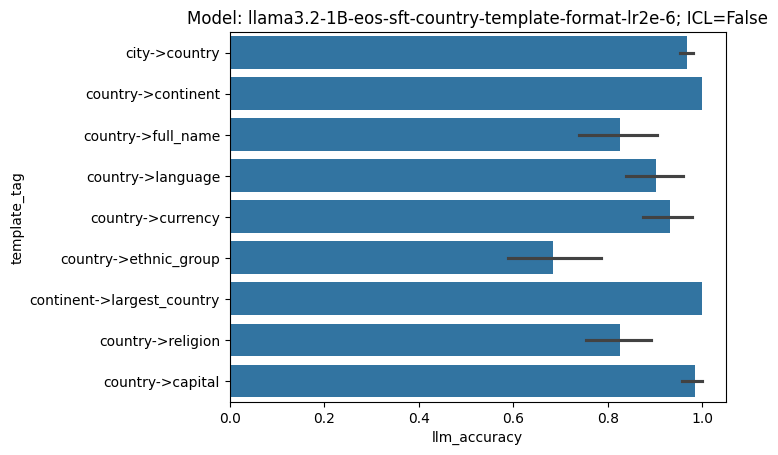

In [ ]:
# sns.histplot(df, x="llm_accuracy", bins=20)

# sns.barplot(data=pd.concat([selected_columns_ood_df, selected_columns_country_df]), x="llm_accuracy", y="template_tag",  orient="h",)
# sns.barplot(data=df, x="llm_accuracy", y="template_tag",  orient="h",)
sns.barplot(data=valid_df, x="llm_accuracy", y="template_tag",  orient="h",)
plt.title(f"Model: {model_name}; ICL={add_icl}")
# plt.show()

# sns.barplot(data=df, x="llm_accuracy", y="key", hue="domain", orient="h", errorbar=None, order=result['llm_accuracy'])
# sns.barplot(data=df.groupby("key").describe()["llm_accuracy"].reset_index().sort_values(by=["mean"], ascending=False), x="mean", y="key", orient="h", errorbar=None,)

In [163]:
sampled_dfs = []
sample_per_template = 10
for template_df in df.groupby("template_tag"):
    sampled_dfs.append(template_df[1].sample(sample_per_template))

In [75]:
1920 * 1.5

2880.0

In [ ]:
# io.dump_jsonlines(pd.concat(sampled_dfs).to_dict("records"), "/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/llama3.2-1B-eos-sft_country_templates_format_training_v2.jsonl")

In [ ]:
acc_by_country_df = df.groupby("key").describe()["llm_accuracy"].reset_index()

In [27]:
acc_by_country_df.sort_values(by=["mean"], ascending=False).iloc[-20:]

,key,count,mean,std,min,25%,50%,75%,max
8,Bolivia,8.0,0.800000,0.374166,0.1,0.825,1.0,1.00,1.0
75,Zambia,9.0,0.800000,0.396863,0.1,1.000,1.0,1.00,1.0
20,Ethiopia,9.0,0.800000,0.396863,0.1,1.000,1.0,1.00,1.0
18,Ecuador,9.0,0.800000,0.396863,0.1,1.000,1.0,1.00,1.0
46,New Zealand,18.0,0.800000,0.385013,0.1,1.000,1.0,1.00,1.0
44,Mozambique,9.0,0.800000,0.396863,0.1,1.000,1.0,1.00,1.0
30,Iceland,10.0,0.790000,0.375500,0.1,0.775,1.0,1.00,1.0
72,United States,24.0,0.787500,0.369856,0.1,0.700,1.0,1.00,1.0
10,Canada,18.0,0.772222,0.381646,0.1,0.475,1.0,1.00,1.0
26,Ghana,9.0,0.766667,0.390512,0.1,0.700,1.0,1.00,1.0


In [14]:
country = acc_by_country_df.sort_values(by=["mean"], ascending=False)["key"].tolist()[-10:]

In [22]:
country

['Cuba',
 'Argentina',
 'Uruguay',
 'United Kingdom',
 'Zimbabwe',
 'Georgia',
 'Singapore',
 'Maldives',
 'Democratic Republic of the Congo',
 'French Polynesia']

In [21]:
# country

In [18]:
df["template_tag"].unique()

array(['city->country', 'country->continent', 'country->full_name',
       'country->capital', 'country->language', 'country->currency',
       'country->ethnic_group', 'continent->largest_country',
       'country->religion'], dtype=object)

In [19]:
# template_tags_for_format = ["country->currency", "country->ethnic_group"]

In [25]:
country_templates_format_training_df = df[df["template_tag"].isin(template_tags_for_format) & df["key"].isin(country)]

In [26]:
len(country_templates_format_training_df)

20

In [3]:
a = io.load_json("/u/zliu/datastor1/ReCoE/data/superlative/counterfactual_datapoints_verified_atomic.json")

In [ ]:
# io.dump_jsonlines(country_templates_format_training_df.to_dict(orient="records"), f"{vars.DATA_DIR}/debug_meta_train/{model_name}_country_templates_format_training.jsonl")

In [259]:
top_country_noICL = top_country

In [271]:
len(set(top_country).intersection(set(top_country_noICL)))

45

In [ ]:
# Country: 602 knowledge
# Year: 681 knowledge

In [67]:
len(set(df["question"].to_list()))

1025

In [72]:
known_knowledge = df[df["llm_accuracy"] > 0.5]["question"]

In [ ]:
#  len(set(known_knowledge))

600

In [62]:
len(known_knowledge) == len(set(known_knowledge))

False